# CRISPR Screening Workshop: Part 2

## Identifying LDLR variant effects using saturation prime editing

This notebook will walk you through how CRISPR screening can reveal the effect of different genetic variants on the gene LDLR's ability to facilitate cholesterol uptake. The data in this notebook originates from the preprint "LDLR variant classification through activity-normalized prime editing screening" accessible at the following link: 
https://www.biorxiv.org/content/10.64898/2025.12.16.694467v1.

The low density lipoprotein receptor (LDLR) is a critical player in the uptake of low density lipoprotein (LDL), or "bad cholesterol" from the bloodstream. Familial hypercholesterolemia, a genetic disorder that causes high cholesterol, is often caused by genetic variants in LDLR. Even in large biobanks such as the UK BioBank, many LDLR variants are not observed and thus it is impossible to gauge the effect of the majority of LDLR variants on circulating cholesterol. To address this gap in knowledge, our group has developed a CRISPR screen based on a genome editing technology called prime editing to systematically assess the effect of 5184 variants on LDL uptake in human cells. In this workshop and the preprint, we aim to address the following questions:

**1. How can we design a library of prime editing guide RNAs to assess LDLR variant effect?**

**2. How well do our functional scores correlate with “common-sense” variant effect measurements?**

**3. How do LDLR variant effects relate to protein structure and protein-protein interactions?**

**4. Why prime editing instead of cDNA overexpression-based deep mutational scanning?**

Let's first install some libraries to load and visualize the screen data, and load in a summary file for the prime editing library.

In [746]:
try:
    import nglview
except ImportError:
    !pip -q install nglview

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xlrd
from pathlib import Path
import os
import nglview as nv
import ipywidgets as widgets
from IPython.display import display
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr
import matplotlib.image as mpimg

In [ ]:
#Load in a summary file for the prime editing library

REPO_URL = "https://github.com/pzhou1729/2026_CRISPRscreen_GeneticsBootcamp.git"
REPO_DIR = Path("/content/2026_CRISPRscreen_GeneticsBootcamp")

# Clone once per runtime
if not REPO_DIR.exists():
    !git clone -q {REPO_URL}

ROOT = REPO_DIR

#location of the data directory, which contains the Excel spreadsheet of effect sizes and pegRNAs
data_dir = ROOT / "data"

LDLR_PE_FL_library = pd.read_excel(
    data_dir / "LDLR_PE_FL_library.xlsx"
)

#Display the library
LDLR_PE_FL_library

,Variant,Starting AA,Position,Variant AA,Original_nts,Variant_nts,Spacer sequence,pegRNA sequence,Oligo sequence,PRIDICT2.0 score HEK,PRIDICT2.0 score K562,Variant type,Reporter BEAN edit percentage,Reporter BEAN edit fraction,Reporter BEAN mu,Endogenou BEAN mu SD,Reporter BEAN Z score,Reporter BEAN SD,Reporter BEAN Z score SD<1,Reporter FUSE score
0,G2_,G,2.0,_,GGG,TGA,GGGCAGAGGCTGCGAGCATG,GGGCAGAGGCTGCGAGCATGGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGGGCAGAGGCTGCGAGCATGGTTTCA...,77.647743,44.914201,stop,86.966965,0.869670,-0.232553,0.070351,-3.305622,0.070351,-3.305622,0.760218
1,G2E,G,2.0,E,GGG,GAA,GGGCAGAGGCTGCGAGCATG,GGGCAGAGGCTGCGAGCATGGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGGGCAGAGGCTGCGAGCATGGTTTCA...,75.478140,32.439968,missense,76.663561,0.766636,0.059496,0.070336,0.845876,0.070336,0.845876,0.388119
2,G2G,G,2.0,G,GGG,GGC,GCAGCGCAATTTCCAGCCCC,GCAGCGCAATTTCCAGCCCCGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGCAGCGCAATTTCCAGCCCCGTTTCA...,68.478677,29.940411,synonymous,22.090075,0.220901,0.840063,0.384273,2.186110,0.384273,2.186110,0.093340
3,G2R,G,2.0,R,GGG,AGA,GGGCAGAGGCTGCGAGCATG,GGGCAGAGGCTGCGAGCATGGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGGGCAGAGGCTGCGAGCATGGTTTCA...,76.779988,40.441675,missense,6.527336,0.065273,0.281295,1.037094,0.271234,1.037094,NaN,NaN
4,G2S,G,2.0,S,GGG,AGC,GGGCAGAGGCTGCGAGCATG,GGGCAGAGGCTGCGAGCATGGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGGGCAGAGGCTGCGAGCATGGTTTCA...,76.915118,47.305287,missense,48.340667,0.483407,0.275370,0.130366,2.112283,0.130366,2.112283,0.283444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Control_95,NaN,NaN,NaN,NaN,NaN,TAAGAAATGTGCACAGGAA,GTAAGAAATGTGCACAGGAAGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGTAAGAAATGTGCACAGGAAGTTTCA...,NaN,NaN,negcontrol,2.731832,0.027318,1.658499,0.742158,2.234697,0.742158,2.234697,NaN
5996,Control_96,NaN,NaN,NaN,NaN,NaN,TGGTAAGGAAGTCACGTGC,GTGGTAAGGAAGTCACGTGCGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGTGGTAAGGAAGTCACGTGCGTTTCA...,NaN,NaN,negcontrol,14.184906,0.141849,0.599264,0.281477,2.129000,0.281477,2.129000,NaN
5997,Control_97,NaN,NaN,NaN,NaN,NaN,TGGTAAGGAAGTCACGTGC,GTGGTAAGGAAGTCACGTGCGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGTGGTAAGGAAGTCACGTGCGTTTCA...,NaN,NaN,negcontrol,3.247412,0.032474,-0.515212,1.168950,-0.440748,1.168950,NaN,NaN
5998,Control_98,NaN,NaN,NaN,NaN,NaN,AATGATGTGGTATCTTTTA,GAATGATGTGGTATCTTTTAGTTTCAGAGCTATGCTGGAAACAGCA...,tgtggaaaggacgaaacaccGAATGATGTGGTATCTTTTAGTTTCA...,NaN,NaN,negcontrol,0.193570,0.001936,0.258036,1.467788,0.175799,1.467788,NaN,NaN


## 1. How can we design a library of prime editing guide RNAs to assess LDLR variant effect?

Let's answer some fundamental questions pertaining to this table.
1. How many pegRNAs are there total? 

2. How many control pegRNAs are there?

3. How many of LDLR's amino acids are we able to edit using this pegRNA library?

In [453]:
#How many pegRNAs are there total? 
LDLR_PE_FL_library["Position"].size

6000

In [ ]:
#How many control pegRNAs are there?
int(LDLR_PE_FL_library["Position"].size - LDLR_PE_FL_library["Position"].count())

305

In [455]:
#How many of LDLR's amino acids are we able to edit using this pegRNA library?
LDLR_PE_FL_library["Position"].nunique()

815

What can we say about these numbers? Since LDLR has 860 amino acids total, this means we can edit almost all of its amino acids (94%) using prime editing. For technical reasons, it is not possible to edit every single one, partially due to the fact that prime editing is limited by the proximity of protospacer adjacent motifs (PAMs) relative to the protospacer and the length of a pegRNA's reverse transcription template.

Our library has 6000 members total. LDLR has 860 amino acids, and there are 21 possible mutational outcomes for each amino acid (19 missense mutations, 1 sense mutation, 1 nonsense mutation/stop-gain), so in theory there are 860*21 = 18060 outcomes to assess. We opted to use a limited number of library members because of 1) cost and 2) screen quality. The more library members you have, the greater the number of cells per library member on average you require. Since our screen is flow-cytometry based, we are inherently limited by the number of cells we can sort per hour, and thus, limited the scope of our screen to variants we computationally determined to be most informative.

In some cases, many pegRNAs could potentially be used to produce the same editing outcome. We wanted to choose the pegRNAs that we were most confident would lead to high-efficiency editing. Using a program called PRIDICT2.0, we could predict the probability of editing for each of our pegRNAs and enriched for high predicted editing pegRNAs in our library. Let's see how well PRIDICT2.0 was able to predict pegRNA editing efficiencies.

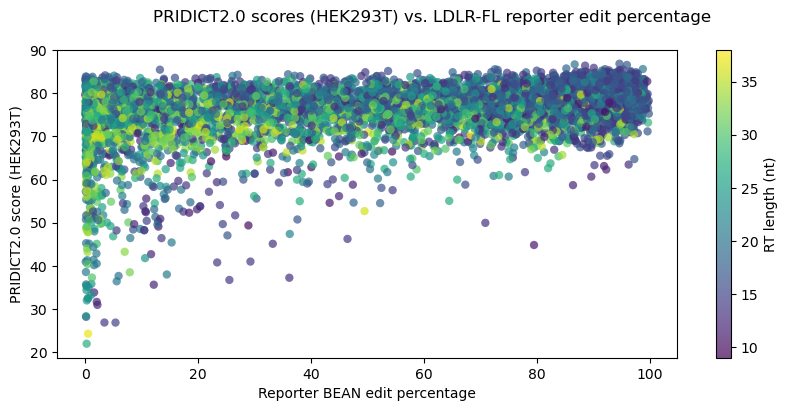

In [693]:
#How well does PRIDICT2.0 predict real LDLR pegRNA editing efficiencies?

#location of the data directory, which contains the Excel spreadsheet of effect sizes and pegRNAs
data_dir = ROOT / "data"

LDLR_PRIDICT = pd.read_excel(
    data_dir / "0125_HCT116_LDLRPE_datasum_Fig_3C.xlsx"
)

#scatterplot of PRIDICT2.0 scores (HEK293T) vs. LDLR-FL reporter edit fraction

plt.figure(figsize=(10, 4))
plt.suptitle("PRIDICT2.0 scores (HEK293T) vs. LDLR-FL reporter edit percentage")

sc = plt.scatter(
    LDLR_PRIDICT["BEAN edit percentage"],
    LDLR_PRIDICT["PRIDICT2_0_editing_Score_deep_HEK"],
    c=LDLR_PRIDICT["RTlength"],      # <-- color by RT length
    cmap="viridis",
    edgecolors="none",
    alpha=0.7
)

plt.xlabel("Reporter BEAN edit percentage")
plt.ylabel("PRIDICT2.0 score (HEK293T)")

cbar = plt.colorbar(sc)
cbar.set_label("RT length (nt)")

plt.show()

The previous figure shows an aggregate of editing efficiencies for all pegRNAs in our library. Each point in the scatterplot is colored by RT template length, which is the most informative feature used for PRIDICT2.0. If you want to look at editing efficiencies for specific RT lengths, you can use the interactive slider below to toggle between RT lengths.

In [ ]:
# ---- column names ----
xcol = "BEAN edit percentage"
ycol = "PRIDICT2_0_editing_Score_deep_HEK"
ccol_raw = "RTlength"

# ---- clean dataframe ----
plot_df = LDLR_PRIDICT.copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")

# robust RT length cleaning
plot_df["RTlength_clean"] = (
    plot_df[ccol_raw]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
)

plot_df = plot_df.dropna(subset=[xcol, ycol, "RTlength_clean"])
plot_df["RTlength_clean"] = plot_df["RTlength_clean"].astype(int)
ccol = "RTlength_clean"

# ---- slider values (actual RT lengths) ----
rt_vals = sorted(plot_df[ccol].unique())

# ---- fixed colormap ----
norm = mcolors.Normalize(vmin=plot_df[ccol].min(), vmax=plot_df[ccol].max())
cmap = plt.cm.viridis

# ---- output widget for plot ----
output = widgets.Output()

# ---- plotting function (accepts either a widget change dict or a raw value) ----
def plot_for_rt(change):
    rt_len = change["new"] if isinstance(change, dict) else change
    rt_len = int(rt_len)

    with output:
        output.clear_output(wait=True)

        df_sel = plot_df[plot_df[ccol] == rt_len]

        fig, ax = plt.subplots(figsize=(10, 4))
        fig.suptitle("PRIDICT2.0 scores (HEK293T) vs. LDLR-FL reporter edit percentage")

        # background points
        ax.scatter(
            plot_df[xcol],
            plot_df[ycol],
            color="black",
            alpha=0.06,
            edgecolors="none"
        )

        # highlighted RT length
        ax.scatter(
            df_sel[xcol],
            df_sel[ycol],
            c=df_sel[ccol],
            cmap=cmap,
            norm=norm,
            edgecolors="none",
            alpha=0.95,
            s=40
        )

        ax.set_xlabel("Reporter BEAN edit percentage")
        ax.set_ylabel("PRIDICT2.0 score (HEK293T)")
        ax.set_title(f"RT length = {rt_len} nt (n = {len(df_sel)})", fontsize=10)

        # colorbar
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label("RT length")

        plt.tight_layout()
        plt.show()

# ---- SelectionSlider with (label, value) tuples (avoids float index bug) ----
rt_slider = widgets.SelectionSlider(
    options=[(str(v), int(v)) for v in rt_vals],  # label shown, actual int stored
    value=int(rt_vals[0]),
    description="RT length (nt):",
    continuous_update=False
)

rt_slider.observe(plot_for_rt, names="value")
rt_slider.style = {"description_width": "140px"}
rt_slider.layout = widgets.Layout(width="600px")

# ---- initial plot ----
plot_for_rt(rt_slider.value)

# ---- display ----
display(rt_slider, output)

SelectionSlider(continuous_update=False, description='RT length (nt):', layout=Layout(width='600px'), options=…

Output()

Now let's see what we can do with our prime editing screen effect sizes. We load in the table containing the effect sizes and pegRNA information.

In [14]:
#read the xlsx file 
LDLR_effect_size_summary = pd.read_excel(
    data_dir / "LDLR_effect_size_summary.xlsx",
)

#view the data 
LDLR_effect_size_summary

,Variant ID,Starting AA,Position,Final AA,LDLRA domain,LDLRA position within domain,Differential PFAM,AlphaMissense,ClinicalSignificance,gold_star,...,Ryu et al 2024 FUSE,LDLR137-219 BEAN mu_Z,LDLR137-219 FUSE,LDLR-FL BEAN mu_Z,LDLR-FL FUSE,Combined PE-FUSE score,Tabet LDL uptake score,Tabet LDL uptake score flipped sign,Tabet Surf abund score,Tabet LDL uptake w VLDL score
0,G2A,G,2,A,NaN,NaN,NaN,0.1019,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.964176,-0.964176,1.021534,0.907896
1,G2C,G,2,C,NaN,NaN,NaN,0.2133,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.433348,-0.433348,1.057672,0.949925
2,G2D,G,2,D,NaN,NaN,NaN,0.1414,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G2E,G,2,E,NaN,NaN,NaN,0.1412,0,0,...,NaN,NaN,NaN,0.845876,0.388119,0.388119,NaN,NaN,NaN,NaN
4,G2F,G,2,F,NaN,NaN,NaN,0.1756,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16316,A860S,A,860,S,NaN,NaN,NaN,0.0670,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.920912,-0.920912,0.808498,NaN
16317,A860T,A,860,T,NaN,NaN,NaN,0.0763,0,0,...,NaN,NaN,NaN,-1.119977,0.422234,0.422234,-0.327146,0.327146,-0.216353,NaN
16318,A860V,A,860,V,NaN,NaN,NaN,0.0836,Conflicting classifications of pathogenicity,0,...,NaN,NaN,NaN,-0.387369,0.417555,0.417555,0.954631,-0.954631,0.993842,NaN
16319,A860W,A,860,W,NaN,NaN,NaN,0.2668,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.011952,-1.011952,0.958833,NaN


**So, what are our functional scores and how are they calculated?**

They are called BEAN z-scores. They come from a paper published by our lab in collaboration with Luca Pinello's lab (Ryu et al. 2024). BEAN stands for **base editor** screen analysis with **activity normalization**, and is applied after raw sequencing data is collected. Briefly, cells expressing prime editors are transduced with a library of pegRNAs, fed with fluorescent LDL, and sorted based on fluorescence quantile-defined bins (0-20%, 20-40%, 60-80%, 80-100% most fluorescent). Genomic DNA is extracted from each of these bins and sequences are amplified through next-generation sequencing (NGS) that 1) tell us what pegRNA was present in a particular cell (barcode) and 2) how efficiently the pegRNA was able to edit LDLR in the cell (reporter). The NGS data are then fed through the BEAN pipeline, which assigns an effect size to each point (a BEAN z-score).

There are also columns in the spreadsheet with the term "FUSE score". These are BEAN scores that have been passed through the FUSE pipeline (Yu et al. 2024), which performs "shrinkage estimation" to push all effect sizes towards a global mean value, and also reverses the magnitude of all scores to allow them to act as pathogenicity prediction scores. FUSE tends to obscure extreme values, which is why it is more useful for clinical calibration than studying rare GOF or LOF variants.

If you are curious about the details, BEAN obtains the effect size for a given pegRNA through the following process.

For each gRNA, BEAN defines a Dirichlet–multinomial likelihood. This likelihood depends on:

1. A vector of expected bin probabilities $\boldsymbol{p_g}$.
	​
2. A vector of bin- and replicate-specific scaling factors $\boldsymbol{s_r}$.
	​

The vector $\boldsymbol{p_g}$​ is derived from a latent random variable $Y_g$, which represents the fluorescence of a randomly chosen cell carrying gRNA $g$. BEAN models $Y_g$ as a mixture normal distribution.  For a given fluorescence shift parameter $\mu$, the entries of $\boldsymbol{p_g}$ are the probabilities that $Y_g$
 falls between the lower and upper sorting thresholds $q_\ell$ and $q_h$ defining each fluorescence bin. (For example, for the 0-20% bin, $\ell = 0$ and $h =20$.)

The Dirichlet multinomial is a probability distribution over count vectors; given expected bin proportions and dispersion parameters, it assigns a probability to observing a particular vector of sequencing counts across bins.

BEAN evaluates this likelihood for many possible values of the fluorescence shift parameter $\mu$. Combining these likelihoods with a prior over $\mu$ yields a posterior distribution over fluorescence shifts.

The mean and variance of this posterior distribution summarize the inferred effect size and its uncertainty ($\mu$). Finally, the standardized effect size is obtained by converting this estimate into a z-score and rescaling it so that negative control or synonymous variants follow a standard normal distribution ($\mu_z$ adjusted).

## 2) How well do our functional scores correlate with “common-sense” variant effect measurements?

We want some indication that our LDLR prime editing screen produces coherent results. A way to do this is to compare our scores to "gold-standard" scores of variant pathogenicity and evolutionary conservation. We opt to use AlphaMissense and a score we call "differential PFAM" towards this end.

**AlphaMissense** is a variant pathogenicity predictor that leverages population frequency data and protein structure prediction to assign a probability of pathogenicity (within the interval $[0,1]$) to every genetic variant in the human proteome (Cheng et al. 2023).

The **differential PFAM** score is calculated from the PFAM database. PFAM contains a multiple sequence alignment of the known 244,445 LDLR class A domains, which is used to calculate a conservation score for each amino acid within the class A repeat. Differential PFAM is then calculated as follows: $$\text{Differential PFAM} = \log_{2}(f_{\text{variant}}) - \log_{2}(f_{\text{wild-type}}).$$

Let's try making scatterplots of LDLR effect sizes versus Differential PFAM and AlphaMissense. For the "**color**" argument, you can change it to "cysteine", "positive", "negative", "polar", or "hydrophobic" to color different categories of mutated amino acid and see whether there are any coherent trends with regards to effect size, evolutionary conservation, or predicted pathogenicity. 

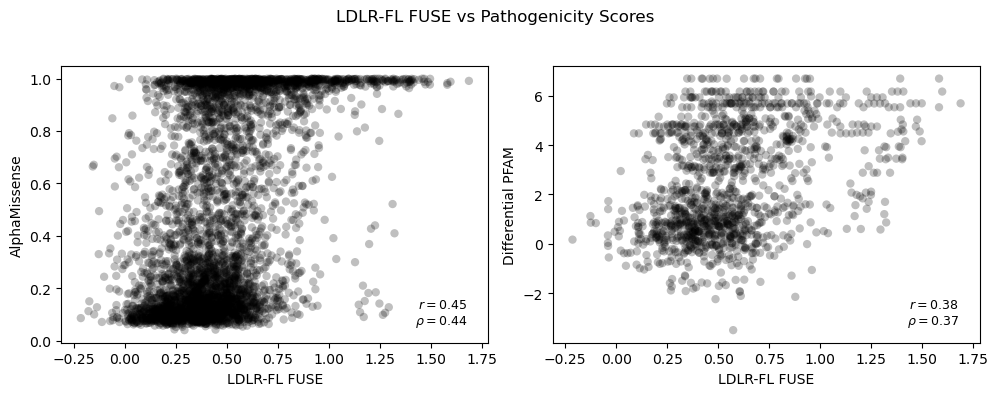

In [659]:
#Dataframe of starting amino acid identities
aa = LDLR_effect_size_summary['Starting AA']

#Try changing the argument in color = to cysteine, positive, negative, polar, or hydrophobic!

#cysteine = all variants who start with the amino acid cysteine
#positive = all variants who start with a positive amino acid
#negative = all variants who start with a negative amino acid
#polar = all variants who start with a polar amino acid
#hydrophobic = all variants who start with a hydrophobic amino acid

cysteine = aa.map(lambda v: 'yellow' if v in ['C'] else 'black')
positive = aa.map(lambda v: 'red' if v in ['R', 'H', 'K'] else 'black')
negative = aa.map(lambda v: 'blue' if v in ['D', 'E'] else 'black')
polar = aa.map(lambda v: 'pink' if v in ['S', 'T', 'N', 'Q'] else 'black')
hydrophobic = aa.map(lambda v: 'green' if v in ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W'] else 'black')


plt.figure(figsize=(10, 4))
plt.suptitle("LDLR-FL FUSE vs Pathogenicity Scores")

# ---------- Panel 1: AlphaMissense ----------
x1 = LDLR_effect_size_summary["LDLR-FL FUSE"]
y1 = LDLR_effect_size_summary["AlphaMissense"]

mask1 = x1.notna() & y1.notna()
r_p1, p_p1 = pearsonr(x1[mask1], y1[mask1])
r_s1, p_s1 = spearmanr(x1[mask1], y1[mask1])

plt.subplot(1, 2, 1)
plt.scatter(
    x1, y1,
    edgecolors="none",
    color="black",
    alpha=0.25
)
plt.xlabel("LDLR-FL FUSE")
plt.ylabel("AlphaMissense")

plt.text(
    0.95, 0.05,
    rf"$r = {r_p1:.2f}$" "\n" rf"$\rho = {r_s1:.2f}$",
    transform=plt.gca().transAxes,
    fontsize=9,
    horizontalalignment="right",
    verticalalignment="bottom"
)

# ---------- Panel 2: Differential PFAM ----------
x2 = LDLR_effect_size_summary["LDLR-FL FUSE"]
y2 = LDLR_effect_size_summary["Differential PFAM"]

mask2 = x2.notna() & y2.notna()
r_p2, p_p2 = pearsonr(x2[mask2], y2[mask2])
r_s2, p_s2 = spearmanr(x2[mask2], y2[mask2])

plt.subplot(1, 2, 2)
plt.scatter(
    x2, y2,
    edgecolors="none",
    color="black",
    alpha=0.25
)
plt.xlabel("LDLR-FL FUSE")
plt.ylabel("Differential PFAM")

plt.text(
    0.95, 0.05,   # bottom-right in axes coords
    rf"$r = {r_p2:.2f}$" "\n" rf"$\rho = {r_s2:.2f}$",
    transform=plt.gca().transAxes,
    fontsize=9,
    horizontalalignment="right",
    verticalalignment="bottom"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

If you try to highlight cysteines, you will notice that they have high AlphaMissense and Differential PFAM scores. This reflects known biology: cysteines are essential for maintaining the structure of domains called class A repeats in LDLR, and mutating these cysteines destabilizes the structure of the protein, rendering it unable to bind to its ligands properly (citation needed).

A caveat to this analysis is that we are also ultimately interested in how our variant analysis correlates with the clinically relevant metric: circulating LDL levels. Unfortunately, since UK Biobank data is protected, we can't generate plots correlating our effect sizes and LDL-C levels here, but these are presented in our preprint.

We can see from these correlations that our scores generally correlate well with pathogenicity and conservation predictors. Another way to explore our data is to look at a more granular level for specific variants of interest, with an eye towards protein structure.

## 3) How do LDLR variant effects relate to protein structure and protein-protein interactions?

How might LDLR variants map onto the LDLR protein structure? To probe at this, we can look at a structure of LDLR bound to one its ligands APOB, which is an essential structural component of LDL particles. 

In [ ]:
#PDB id: 9bdt
#Legobodies are removed from the structure for simplicity
#LDLR class A repeats are colored pink, and APOB is colored gray

from google.colab import output
output.enable_custom_widget_manager()

view = nv.show_file(str(data_dir / "9bdt.pdb"))
view.clear_representations()
view.add_cartoon(selection=":R", color="lightpink")
view.add_cartoon(selection=":A", color="gray")
view

NGLWidget()

The structure 9bdt depicts the bound structure of APOB-LDLR. APOB is a massive protein (4563 amino acids long) and forms a belt-like structure around the diameter of the LDL particle. The seven class A repeats of LDLR wrap around a subsection of the APOB belt. For more information about this costructure, feel free to consult Reimund et al. 2025.

In [ ]:
LDLR_effect_size_summary["domain"] = np.select(
    [
        LDLR_effect_size_summary["Position"].between(25, 313),
        LDLR_effect_size_summary["Position"].between(314, 393),
        LDLR_effect_size_summary["Position"].between(397, 658),
        LDLR_effect_size_summary["Position"].between(663, 712),
    ],
    [
        "LDLR class A",
        "EGF-like",
        "LDLR class B",
        "EGF-like",
    ],
    default="Other"
)

LDLR_effect_size_summary["domain_color"] = np.select(
    [
        LDLR_effect_size_summary["domain"].eq("LDLR class A"),
        LDLR_effect_size_summary["domain"].eq("EGF-like"),
        LDLR_effect_size_summary["domain"].eq("LDLR class B"),
    ],
    [
        "#60C3D1",
        "#C3C45E",
        "#CF4D44",
    ],
    default="#BCBCBC"
)


# --- Define LDLR class A repeat boundaries ---
repeat_bounds = {
    1: (25, 65),
    2: (66, 106),
    3: (107, 145),
    4: (146, 186),
    5: (195, 233),
    6: (234, 272),
    7: (274, 313),
}

# --- Slider (just 1–7) ---
repeat_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=7,
    step=1,
    description="Repeat:",
    continuous_update=False,
    style={"description_width": "70px"},
    layout=widgets.Layout(width="500px")
)

out = widgets.Output()

def draw_plot(change=None):
    rep = int(repeat_slider.value)
    left, right = repeat_bounds[rep]

    with out:
        out.clear_output(wait=True)

        plt.figure(figsize=(10, 4))
        plt.suptitle(f"LDLR-FL BEAN z score vs AA position — class A repeat {rep} highlighted ({left}–{right})")

        plt.scatter(
            LDLR_effect_size_summary["Position"],
            LDLR_effect_size_summary["LDLR-FL BEAN mu_Z"],
            edgecolors="none",
            color=LDLR_effect_size_summary["domain_color"],
            alpha=0.25
        )

        # delineate selected class A repeat
        for x in (left, right):
            plt.axvline(x=x, color="black", ls=":")

        # delineate significant z thresholds
        for y in (-1.96, 1.96):
            plt.axhline(y=y, color="black", ls=":")

        plt.text(865, 2.5, "1.96", fontsize=8, fontweight="bold")
        plt.text(860, -2.75, "-1.96", fontsize=8, fontweight="bold")

            
        legend_elements = [
            Line2D([0], [0], marker='o', color='w',
                   label='LDLR class A',
                   markerfacecolor='#60C3D1', markersize=8),
            Line2D([0], [0], marker='o', color='w',
                   label='EGF-like',
                   markerfacecolor='#C3C45E', markersize=8),
            Line2D([0], [0], marker='o', color='w',
                   label='LDLR class B',
                   markerfacecolor='#CF4D44', markersize=8),
        ]
        
        plt.legend(
            handles=legend_elements,
            loc='upper right',
            frameon=False,
            fontsize=9
        )

        plt.xlabel("AA Position")
        plt.ylabel("LDLR-FL BEAN z score")
        plt.show()

repeat_slider.observe(draw_plot, names="value")


draw_plot()
display(repeat_slider, out)

IntSlider(value=5, continuous_update=False, description='Repeat:', layout=Layout(width='500px'), max=7, min=1,…

Output()

Scrolling through the LDLR class A repeats, it is clear that the strongest gain-of-function variants all reside within class A repeat 5. Class A repeat 5 is significant because it is the only class A repeat essential for binding both ligands of LDLR, apolipoprotein B (APOB) and apolipoprotein E (APOE). We were curious to see whether computational predictors of energy changes upon amino acid mutations would highlight our top GOF variants. We tried the following:

**DDMut** is a machine-learning based variant effect predictor that predicts the effect on ΔΔG for single proteins (Zhou et al. 2023).

**FoldX** is a physics-based variant effect predictor that predicts the effect on ΔΔG for single proteins (Schymkowitz et al. 2005).

**DDMut-PPI** is a machine-learning based variant effect predictor that predicts the effect on ΔΔG for protein complexes (Zhou et al. 2024).

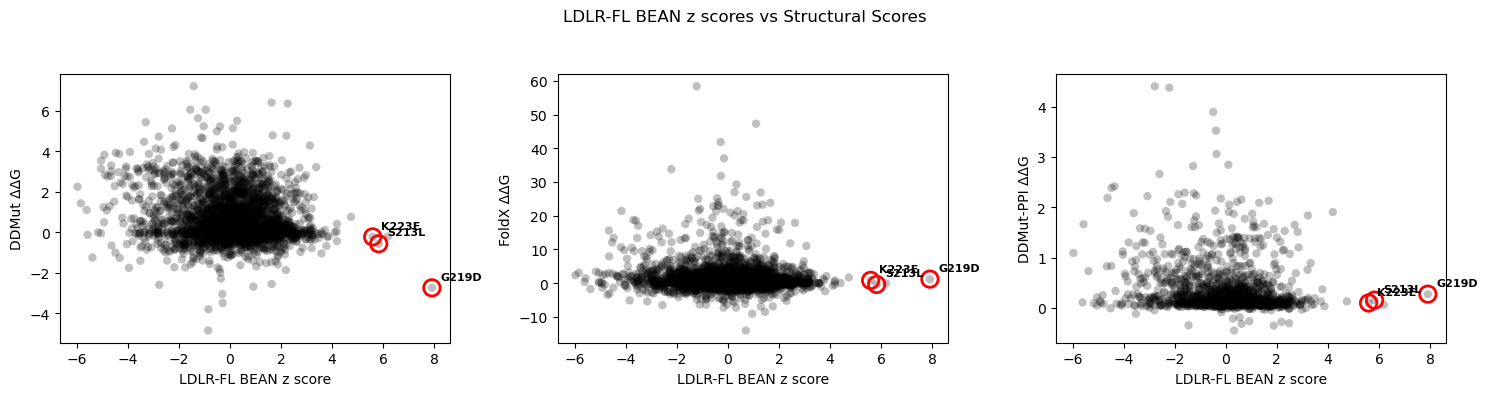

In [685]:
ddmut_LDLR = pd.read_csv( data_dir / "11_19_25_ddmut_LDLR.csv" ) 
FoldX_BEAN = pd.read_csv( data_dir / "11_19_25_FoldX_BEAN.csv" ) 
ddmut_ppi_LDLR_APOB = pd.read_csv( data_dir / "11_19_25_ddmut_ppi_LDLR_APOB.csv" ) 

ddmut_LDLR = LDLR_effect_size_summary.merge( ddmut_LDLR, on="Variant ID", how="inner" ) 
ddmut_LDLR["prediction"] = -1 * ddmut_LDLR["prediction"] 

ddmut_ppi_LDLR_APOB = LDLR_effect_size_summary.merge( ddmut_ppi_LDLR_APOB, on="Variant ID", how="inner" ) 
ddmut_ppi_LDLR_APOB["ddmut.ppi.forward.prediction"] = -1 * ddmut_ppi_LDLR_APOB["ddmut.ppi.forward.prediction"]

highlight_variants = ["G219D", "K223E", "S213L"]

def overlay_highlights(ax, df, xcol, ycol, variants, id_col= "Variant ID",
                       edgecolor="red", s=140, lw=2, label=True):
    """Overlay hollow circles (and optional labels) for selected variants."""
    if id_col not in df.columns:
        return  # nothing to do

    hi = df[df[id_col].isin(variants)].copy()
    if hi.empty:
        return

    # drop NaNs so the overlay doesn't error
    hi = hi.dropna(subset=[xcol, ycol])

    ax.scatter(
        hi[xcol], hi[ycol],
        s=s, facecolors="none", edgecolors=edgecolor,
        linewidths=lw, zorder=10
    )

    if label:
        for _, row in hi.iterrows():
            ax.annotate(
                row[id_col],
                (row[xcol], row[ycol]),
                textcoords="offset points",
                xytext=(6, 6),
                fontsize=8,
                fontweight="bold",
                zorder=11
            )

# --- Make sure each dataset you plot has Variant ID ---
# ddmut_LDLR and ddmut_ppi_LDLR_APOB already do (because you merged).
# FoldX_BEAN: if it doesn't have "Variant ID", merge it the same way:
if "Variant ID" not in FoldX_BEAN.columns and "Variant ID" in LDLR_effect_size_summary.columns:
    # Change "Variant ID" below if your FoldX file uses a different column name
    if "Variant ID" in FoldX_BEAN.columns:
        pass
    else:
        # If FoldX_BEAN has Variant ID under a different name, edit right_on=...
        # Example: right_on="variant_id"
        FoldX_BEAN = LDLR_effect_size_summary.merge(FoldX_BEAN, on="Variant ID", how="inner")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("LDLR-FL BEAN z scores vs Structural Scores")

# 1) DDMut
x1, y1 = "LDLR-FL BEAN mu_Z", "prediction"
axes[0].scatter(ddmut_LDLR[x1], ddmut_LDLR[y1], edgecolors="none", color="black", alpha=0.25)
overlay_highlights(axes[0], ddmut_LDLR, x1, y1, highlight_variants)
axes[0].set_xlabel("LDLR-FL BEAN z score")
axes[0].set_ylabel("DDMut ΔΔG")

# 2) FoldX (edit xcol name if you want to use LDLR-FL BEAN mu_Z instead)
x2 = "bean_element_result.MixtureNormal_HCT116_rep7_normalization0702_muZ_adj_SD<1"
y2 = "total energy"
axes[1].scatter(FoldX_BEAN[x2], FoldX_BEAN[y2], edgecolors="none", color="black", alpha=0.25)
overlay_highlights(axes[1], FoldX_BEAN, x2, y2, highlight_variants)
axes[1].set_xlabel("LDLR-FL BEAN z score")
axes[1].set_ylabel("FoldX ΔΔG")

# 3) DDMut-PPI
x3, y3 = "LDLR-FL BEAN mu_Z", "ddmut.ppi.forward.prediction"
axes[2].scatter(ddmut_ppi_LDLR_APOB[x3], ddmut_ppi_LDLR_APOB[y3], edgecolors="none", color="black", alpha=0.25)
overlay_highlights(axes[2], ddmut_ppi_LDLR_APOB, x3, y3, highlight_variants)
axes[2].set_xlabel("LDLR-FL BEAN z score")
axes[2].set_ylabel("DDMut-PPI ΔΔG")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

As you can see, the top variants fail to show strong effects in all structural predictions (save for G219D in DDMut's predictions, which does actually suggest G219D increases protein stability). 

As an alternative form of analysis, we wanted to see whether individual LDLR GOF variants modify the predicted interatom interactions between LDLR and its ligand APOB. 

(-0.5, 1499.5, 1084.5, -0.5)

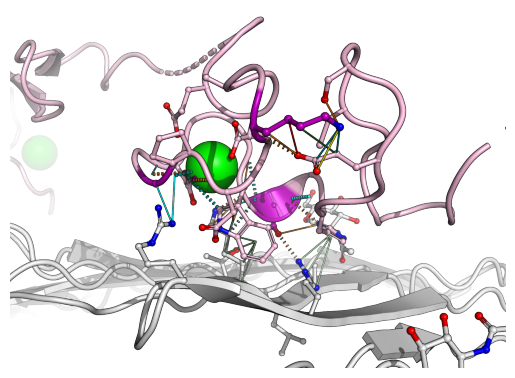

In [750]:
img = mpimg.imread(data_dir / "LDLR_APOB_Arpeggio.png")
plt.imshow(img)
plt.axis("off")

Here is a visualization of the LDLR class A repeat 5 (in pink) complexed with APOB (in white). Amino acids of interest (S213, G219, K223) are colored in purple.

(-0.5, 1499.5, 1116.5, -0.5)

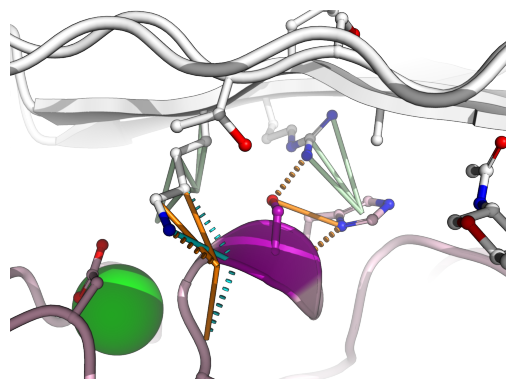

In [752]:
img = mpimg.imread(data_dir / "LDLR_APOB_S213_wt.png")
plt.imshow(img)
plt.axis("off")

(-0.5, 1499.5, 1084.5, -0.5)

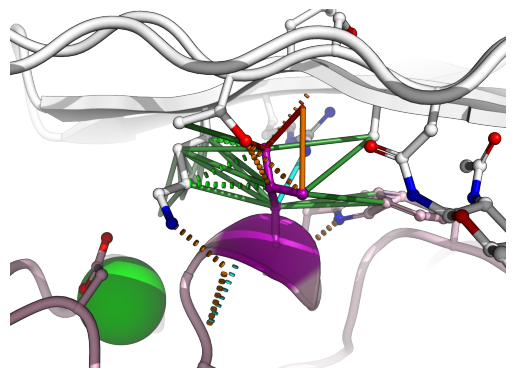

In [754]:
img = mpimg.imread(data_dir / "LDLR_APOB_S213L.png")
plt.imshow(img)
plt.axis("off")

When viewing S213 compared to L213, more hydrophobic interactions (in green) are generated.

(-0.5, 1499.5, 1116.5, -0.5)

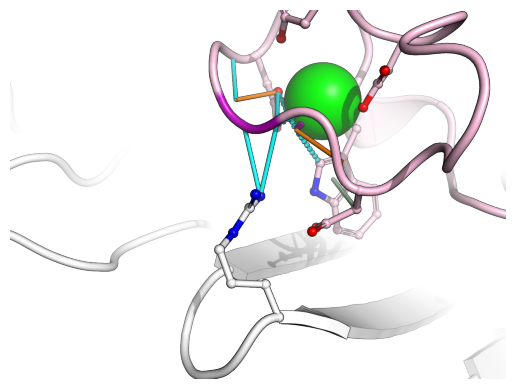

In [744]:
img = mpimg.imread(data_dir / "LDLR_APOB_G219_wt.png")
plt.imshow(img)
plt.axis("off")

(-0.5, 1499.5, 1084.5, -0.5)

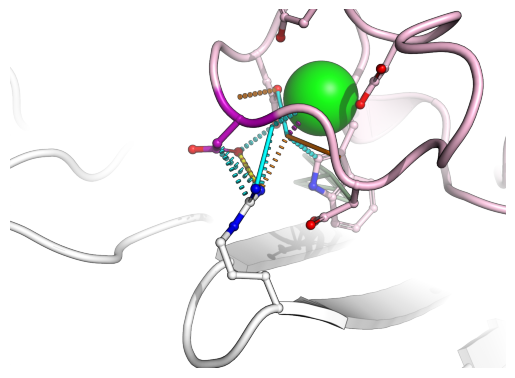

In [756]:
img = mpimg.imread(data_dir / "LDLR_APOB_G219D.png")
plt.imshow(img)
plt.axis("off")

Similarly, when viewing G219 and D219, a novel ionic interaction is created between LDLR and APOB. This suggests a potential hypothesis: that S213L and G219D may act through increasing affinity of LDLR for its ligands, which we can then validate through further biochemical experiments.

## 4) Why prime editing instead of cDNA overexpression-based deep mutational scanning?

While in the process of writing our preprint, a paper published by Tabet et al. was published that also performed deep mutational scanning of LDLR with similar aims to ours. However, a key difference between their approach and ours is that while they measure LDL uptake from LDLR variants overexpressed from a safe site in the genome, we measure LDL uptake from LDLR variants introduced in the endogenous genome via prime editing. Their strategy for measuring variant LDL uptake enrichment also differs from ours in terms of the number of bins used during fluorescence activated cell sorting (FACS). These methodological differences drive two substantial differences that we see between our screen and ours, namely that 1) we detect hypermorphic variants not detected in theirs and 2) our strategy in theory allows for the detection of RNA splicing effects on LDLR expression.

### 1) Hypermorphic variants
When comparing our results to theirs, we observe that G219D, K223E, and S213L, the top GOF variants in our prime editing screen, do not show up as strongly GOF in their screen as well. We are not entirely sure what explains this discrepancy, but there are two methodological differences between our screen and theirs which may contribute.

In the BEAN paper, we found that using a greater number of bins during FACS increases our prediction accuracy. Thus, we opted to utilize four different bins when sorting cells by phenotype, as opposed to the strategy employed by Tabet et al., which used a single top 20% fluorescence bin. 

Furthermore, in Tabet, they collected cells post-FACS, cultured them, and once they hit a critical mass, their gDNA was extracted and used for NGS. We opted to process the cells immediately after FACS instead of culturing them for days afterward.

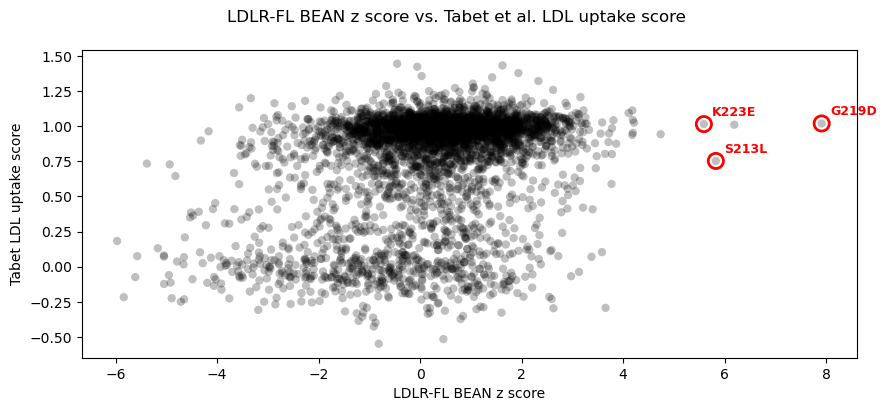

In [728]:
#scatterplot of Tabet LDLR vs. BEAN z-scores for LDLR-FL

highlight_variants = ["G219D", "K223E", "S213L"]

highlight_df = LDLR_effect_size_summary[
    LDLR_effect_size_summary["Variant ID"].isin(highlight_variants)
]

plt.figure(figsize=(10, 4))
plt.suptitle("LDLR-FL BEAN z score vs. Tabet et al. LDL uptake score")

#LDLR-FL BEAN mu_z vs. AlphaMissense
plt.scatter(
    LDLR_effect_size_summary["LDLR-FL BEAN mu_Z"],
    LDLR_effect_size_summary["Tabet LDL uptake score"],
    edgecolors="none",
    color="black",
    alpha=0.25
)

plt.scatter(
    highlight_df["LDLR-FL BEAN mu_Z"],
    highlight_df["Tabet LDL uptake score"],
    s=120,                    # circle size
    facecolors="none",        # hollow
    edgecolors="red",         # outline color
    linewidths=2,
    zorder=10
)

for _, row in highlight_df.iterrows():
    plt.annotate(
        row["Variant ID"],
        (row["LDLR-FL BEAN mu_Z"], row["Tabet LDL uptake score"]),
        textcoords="offset points",
        xytext=(6, 6),
        fontsize=9,
        color = "red",
        fontweight="bold"
    )

plt.xlabel("LDLR-FL BEAN z score")
plt.ylabel("Tabet LDL uptake score")

plt.show()

### 2) RNA splicing

To assess splicing, we used AlphaGenome (Avsec et al. 2025) to predict the change in splicing probability for each genetic variant across LDLR's coding sequence. Our top three hits (i.e., the variants that decreased the likelihood of splicing the most) were in the amino acids E615, T713, and Q770.

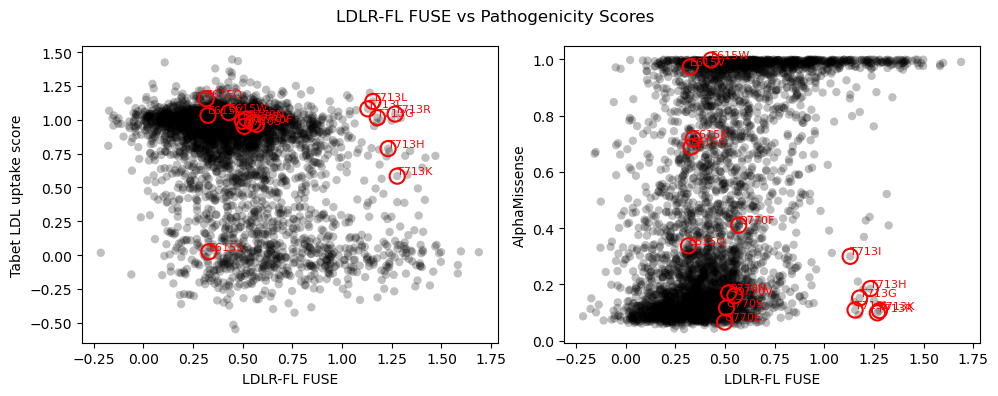

In [308]:
highlight_positions = [615, 713, 770]

plt.figure(figsize=(10, 4))
plt.suptitle("LDLR-FL FUSE vs Pathogenicity Scores")

xcol = 'LDLR-FL FUSE'
y1col = 'Tabet LDL uptake score'
y2col = 'AlphaMissense'
labcol = 'Variant ID'

# Subplot 1
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(
    LDLR_effect_size_summary[xcol],
    LDLR_effect_size_summary[y1col],
    color="black",
    alpha=0.25,
    edgecolors="none"
)
ax1.set_xlabel("LDLR-FL FUSE")
ax1.set_ylabel("Tabet LDL uptake score")

# Subplot 2
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(
    LDLR_effect_size_summary[xcol],
    LDLR_effect_size_summary[y2col],
    color="black",
    alpha=0.25,
    edgecolors="none"
)
ax2.set_xlabel("LDLR-FL FUSE")
ax2.set_ylabel("AlphaMissense")

# Subset to highlighted positions
highlight_df = LDLR_effect_size_summary[
    LDLR_effect_size_summary["Position"].isin(highlight_positions)
].copy()

# Keep only finite points per subplot (prevents "posx/posy should be finite" spam)
h1 = highlight_df[np.isfinite(highlight_df[xcol]) & np.isfinite(highlight_df[y1col])]
h2 = highlight_df[np.isfinite(highlight_df[xcol]) & np.isfinite(highlight_df[y2col])]

# Overlay highlighted circles (only where they can actually be plotted)
ax1.scatter(
    h1[xcol], h1[y1col],
    facecolors='none', edgecolors='red',
    s=120, linewidths=1.5, zorder=5
)

ax2.scatter(
    h2[xcol], h2[y2col],
    facecolors='none', edgecolors='red',
    s=120, linewidths=1.5, zorder=5
)

# Labels (Variant ID) — only for finite points
for _, row in h1.iterrows():
    ax1.text(
        row[xcol], row[y1col], str(row[labcol]),
        fontsize=8, color='red', ha='left', va='bottom'
    )

for _, row in h2.iterrows():
    ax2.text(
        row[xcol], row[y2col], str(row[labcol]),
        fontsize=8, color='red', ha='left', va='bottom'
    )

plt.tight_layout()

From these plots, variants of the amino acid T713 stick out as being variants that both Tabet and AlphaMissense are unable to recognize. In the left scatterplot, the T713 variants have LDLR-FL FUSE scores on the higher end (~1.2), yet most of those variants have Tabet LDL uptake scores of about 1. Tabet uptake scores are normalized to 1 if they have effects comparable to synonymous mutations. Also, the T713 variants have low AlphaMissense scores yet relatively high FUSE scores, and are really the only points clustering in the bottom right quadrant of the right scatterplot. While we recognize that most splicing variants are in noncoding regions of the genome, prime editing in principle does allow us to discover variant effects that occur due to RNA splicing that would not otherwise be discovered using machine learning techniques or cDNA-based deep mutational screening approaches.

## High level takeaways:

**1. How can we design a library of prime editing guide RNAs to assess LDLR variant effect?**

We design our library such that each pegRNA has the highest predicted editing efficiency possible, and select the maximally informative variants to introduce.

**2. How well do our functional scores correlate with “common-sense” variant effect measurements?**

Modestly well. When we pass our BEAN z scores through the FUSE pipeline, correlations marginally improve.

**3. How do LDLR variant effects relate to protein structure and protein-protein interactions?**

The strongest gain-of-function variants cluster in a specific structural domain of LDLR, which is known to be essential for binding both of LDLR's ligands (Apolipoprotein B/APOB and Apolipoprotein E/APOE). 

**4. Why prime editing instead of cDNA overexpression-based deep mutational scanning?**

Prime editing is able to discover coding variants that affect RNA splicing.
